<a href="https://colab.research.google.com/github/MaricelaMH/SIMULACION-II/blob/main/Caminantes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#M É T O D O - M E T R O P O L I S - HASTINGS - 2D

Este método pertenece a la clase de algoritmos de Monte Carlo con cadenas de Markov. Es útil en situaciones donde la distribución objetivo es difícil de muestrear directamente. En un espacio bidimensional (2D), el algoritmo se adapta para muestrear sobre dos variables.
El enfoque es el mismo que en una dimensión, pero ahora el muestreo y las propuestas se hacen en el plano bidimensional $(x,y)$.

Veamos el comportamiento del método con los siguientes ejemplos.

# EJEMPLO 1: Distribución Normal Bivariada

Describe dos variables aleatorias continuas que siguen una distribución normal conjunta. Se caracteriza por medias, varianzas y una correlación que mide la relación lineal entre las variables.

La función de densidad conjunta de dicha distribución es:

$$f(x,y)= \frac{1}{2\pi\sigma_x\sigma_y\sqrt{1-\rho^2}}exp(-\frac{1}{2(1-\rho^2)} [ \frac{(x-\mu_x)^2}{\sigma^2_x}+\frac{(y-\mu_y)^2}{\sigma^2_y}-\frac{2\rho(x-\mu_x)(y-\mu_y)}{\sigma_x\sigma_y}]) $$

con:
* $\mu_x$ y $\mu_y$: medias de las variables $X$ y $Y$
* $\sigma^2_x$ y $\sigma^2_y$: varianzas de $X$ y $Y$
* $\rho$: coeficiente de correlación que mide la relación lineal entre $X$ y $Y$

In [13]:
# Importamos las librerias necesarias

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import scipy.stats as st           # Proporciona funciones estadísticas
from itertools import accumulate   # Sirve para acumular valores en listas.
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D  # Herramientas para gráficos en 3D

In [14]:
# Definimos nuestra función para la Distribución Normal Bivariada
def bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0,
                 mux=0.0, muy=0.0, sigmaxy=0.0):
    """
    Bivariate Gaussian distribution for equal shape *X*, *Y*.
    See `bivariate normal
    <http://mathworld.wolfram.com/BivariateNormalDistribution.html>`_
    at mathworld.
    """
    Xmu = X-mux  # Diferencia entre X y la media en X
    Ymu = Y-muy  # Diferencia entre Y y la media en Y

    rho = sigmaxy/(sigmax*sigmay)    # Correlación entre X y Y
    z = Xmu**2/sigmax**2 + Ymu**2/sigmay**2 - 2*rho*Xmu*Ymu/(sigmax*sigmay)   # Ecuación del exponente de la normal bivariada
    denom = 2*np.pi*sigmax*sigmay*np.sqrt(1-rho**2)  # Denominador normalizador
    return np.exp(-z/(2*(1-rho**2))) / denom  # Función de densidad de la distribución normal bivariada


* Plot_dist:La siguiente función se encarga de visualizar las muestras generadas en un gráfico bidimensional con líneas de contorno de densidad y los puntos muestreados

In [15]:
def plot_dist(x,y):
    ''' plotting environment we frequently use to visualise the
    sampling algorithms.'''

    sns.set_style('white') # Color del fondo
    plt.rcdefaults()

    # plot contour # Crear un gráfico conjunto con una densidad estimada
    g = sns.JointGrid(x=x, y=y, height=10).plot_joint(sns.kdeplot, n_levels=4, cmap="BuPu", shade=True, shade_lowest=False)

    # add scatter plot of data   # Añade los puntos de la muestra en el gráfico
    g = g.plot_joint(plt.scatter, c="r", s=30, linewidth=1)
    plt.plot(x, y, linestyle='-', marker='', alpha=0.4, )

    # set axis labels
    g.set_axis_labels("$X$", "$Y$")

* Traceplot: La siguinte función nos mostrara los valores acumulados del muestreo a lo largo del tiempo, la media acumulativa de los valores y una línea horizontal que representa el valor de la media real.

In [16]:
def traceplot(x):
    '''traceplot in the x-dimension with the cumulative mean (r)
    and the actual mean (--)'''
    sns.tsplot(x)
    l = list(accumulate(x))
    nl = [v/i for i, v in enumerate(l,1)]
    plt.plot(nl, 'r')
    plt.axhline(y=0.0, color='k', linestyle='--')
    plt.ylabel('x')
    plt.xlabel('Iteration')

* Autocorrelación_plot: Esta función muestra la autocorrelación de los valores de $x$, es decir, qué tan relacionados están los valores actuales con los valores anteriores en la secuencia.

In [17]:
def autocorrelation_plot(x, l):
    '''plots the autocorrelation of x to lag = l'''
    plt.acorr(x - np.mean(x), maxlags=l,  normed=True, usevlines=False);
    plt.xlim((0, 100))
    plt.ylabel('Autocorrelation')
    plt.xlabel('Lag')

In [18]:
# Creamos un vector de medias para $X$ y $Y$ , asi como la matriz de covarianza
mean = np.array([0, 1])
var = np.array([[1, .5], [.5, 1]])

Text(0.5, 0, '$\\pi(x,y)$')

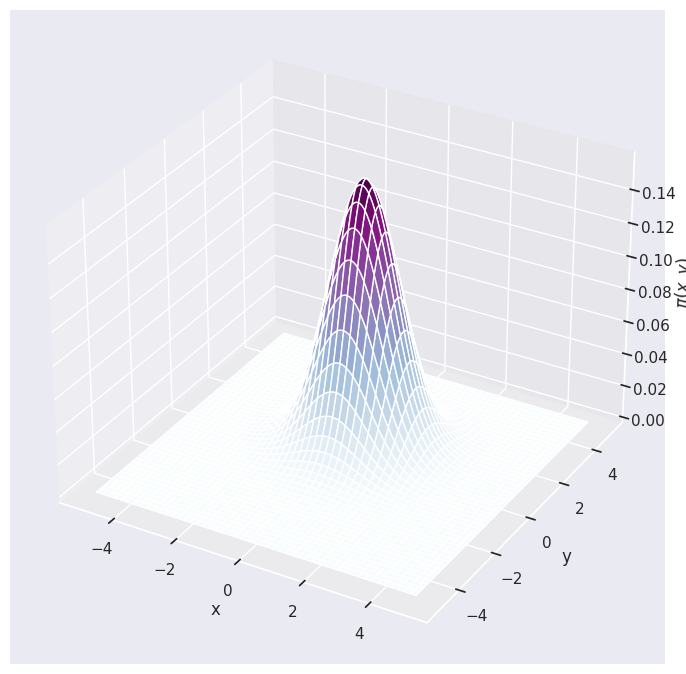

In [19]:
# Creamos la malla de un grafico en 3D
x, y = np.linspace(-5, 5, 200), np.linspace(-5, 5, 200)
X,Y = np.meshgrid(x,y)

# Generate bivariate normal
Z = bivariate_normal(X,Y,var[0][0],var[1][1],mean[0],mean[1]) #Distribucion normal

# plot surface in 3D
fig = plt.figure(figsize=(12,8.5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap= 'BuPu')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$\pi(x,y)$')

### Definimos la 2D distribución objetivo:

Esta función retorna la densidad de probabilidad de la distribución normal multivariante evaluada en el punto $(x,y)$.

In [20]:
def ptarget(x, y):
    return st.multivariate_normal.pdf([x, y], mean=mean, cov=var)

### Construimos un método para el algoritmo Metropolis-Hastings, sus parámetros de entrada serán:
- p: distribución objetivo
- n: número de iteraciones del algoritmo
- x0, y0: punto de partida.
- step: tamaño del paso

In [21]:
def metropolis_hastings(p, n, x0, y0, step):
    x = x0
    y = y0

    points = np.zeros((n, 2)) # Lista inicial de muestras, al momento, con puros ceros

    for i in range(n):

        # Proponemos nuevos valores para el estado actual mediante el muestreo Q(x',y' | x,y)
        x_star, y_star = np.array([x, y]) + np.random.normal(scale=step,size=2)

        # Condición de Metropolis-Hastings
        if np.random.rand() < p(x_star, y_star) / p(x, y):
            x, y = x_star, y_star

        # Se actualiza la lista de muestras
        points[i] = np.array([x, y])

    return points

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1832: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1832: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)


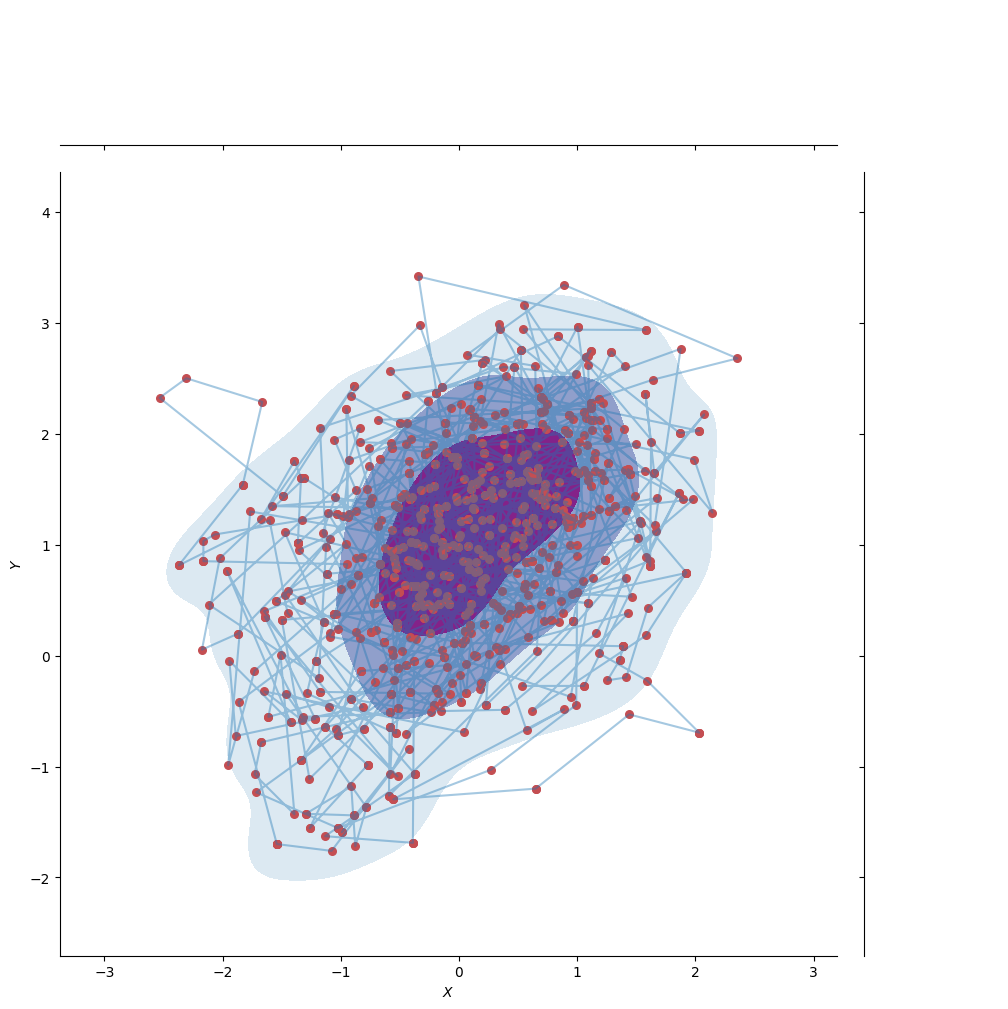

In [22]:
# generate the samples
samples = metropolis_hastings(ptarget, 1000, 1, 1, 0.8) # Para himmelblau

# visualise
plot_dist(samples[:, 0], samples[:, 1])
plt.savefig('caminates.png')

# M E D I A - D E S V. E S T Á N D A R
* **MEDIA:**Para una distribución normal bivariada, cada variable tiene su propia media. Si $x$ y $Y$ son las dos variables aleatorias, entonces a media vectorial de la distribución normal bivariada es:
$$\mu = \begin{pmatrix}
\mu_X \\
\mu_y
\end{pmatrix}$$
por lo que tenemos que
$$\mu = \begin{pmatrix}
0 \\
0
\end{pmatrix}$$

* **VARIANZA:** La varianza de cada variable se expresa como
$$\sigma^2 = \begin{pmatrix}
\sigma^2_X \\
\sigma^2_y
\end{pmatrix}$$
por lo que tenemos que
$$\sigma^2 = \begin{pmatrix}
1 \\
1
\end{pmatrix}$$

por lo que la desviación estándar sera:
$$\sigma = \begin{pmatrix}
\sqrt{\sigma^2_X} \\
\sqrt{\sigma^2_y}
\end{pmatrix}$$
por lo que tenemos que
$$\sigma = \begin{pmatrix}
1 \\
1
\end{pmatrix}$$

demostremos lo anterior de la siguiente manera

In [24]:
# Calcular la media
mean_x = np.mean(samples[:, 0]).round(2)  # Media para X
mean_y = np.mean(samples[:, 1]).round(2)  # Media para Y

# Calcular la varianza
var_x = np.var(samples[:, 0]).round(2)     # Varianza para X
var_y = np.var(samples[:, 1]).round(2)     # Varianza para Y

# Calcular la desviación estándar
std_x = np.std(samples[:, 0]).round(2)     # Desviación estándar para X
std_y = np.std(samples[:, 1]).round(2)     # Desviación estándar para Y

# Imprimir los resultados
print(f"Media de X: {mean_x}, Media de Y: {mean_y}")
print(f"Varianza de X: {var_x}, Varianza de Y: {var_y}")
print(f"Desviación estándar de X: {std_x}, Desviación estándar de Y: {std_y}")

Media de X: 0.04, Media de Y: 0.94
Varianza de X: 0.79, Varianza de Y: 0.99
Desviación estándar de X: 0.89, Desviación estándar de Y: 1.0


# EJEMPLO 2: Distribución Poisson Bivariada

La función de densidad de probabilidad de la distribución Cauchy bivariada se puede expresar como:

$$f(x,y;x_0,y_0;\gamma_x,\gamma_y)=\frac{1}{\pi\gamma_x\gamma_y(1+\frac{(x-x_0)^2}{\gamma^2_x } + \frac{(y-y_0)^2}{\gamma^2_y})}$$

donde:

* $x_0$ y $y_0$: son los parámetros de ubicación, que corresponden a las medianas de las variables $X$ e $Y$.
* $\gamma_x$ y $\gamma_y$: son los parámetros de escala, que determinan la dispersión de las variables.

In [93]:
# Definimos nuestra función para la Distribución Bivariada de Cauchy
def bivariate_cauchy(X1, Y1, mux=0.0, muy=0.0, sigmax=1.0, sigmay=1.0):
    # Cálculo del denominador
    denom = (1 + ((X1 - mux) ** 2 / sigmax ** 2) + ((Y1 - muy) ** 2 / sigmay ** 2))

    return 1 / denom  # Función de densidad de la distribución bivariada de Cauchy


In [94]:
def plot_dist(x,y):

    sns.set_style('white')  # Color del fondo
    plt.rcdefaults()

    # plot contour
    g = sns.JointGrid(x=x, y=y, height=10).plot_joint(sns.kdeplot, n_levels=4,cmap= 'BuPu', shade=True, shade_lowest=False,color='pink')

    # add scatter plot of data
    g = g.plot_joint(plt.scatter, c="r", s=30, linewidth=1)
    plt.plot(x, y, linestyle='-', marker='', alpha=0.4)

    # set axis labels
    g.set_axis_labels("$X$", "$Y$")

In [95]:
def traceplot(x):
    sns.tsplot(x)
    l = list(accumulate(x))
    nl = [v/i for i, v in enumerate(l,1)]
    plt.plot(nl, 'r')
    plt.axhline(y=0.0, color='k', linestyle='--')
    plt.ylabel('x')
    plt.xlabel('Iteration')

In [96]:
def autocorrelation_plot(x, l):
    '''plots the autocorrelation of x to lag = l'''
    plt.acorr(x - np.mean(x), maxlags=l,  normed=True, usevlines=False)
    plt.xlim((0, 100))
    plt.ylabel('Autocorrelation')
    plt.xlabel('Lag')

Text(0.5, 0, '$p(x,y)$')

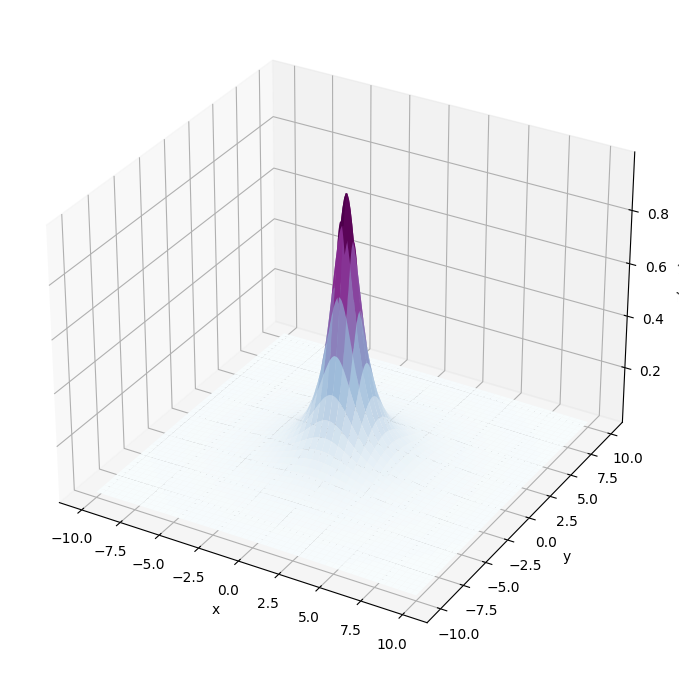

In [97]:
# set mean and scale for Cauchy
mux = 0
muy = 0
sigmax = 1
sigmay = 1

# Creamos la malla de un gráfico en 3D
x, y = np.linspace(-10, 10, 200), np.linspace(-10, 10, 200)  # Aumentamos el rango para la distribución de Cauchy
X, Y = np.meshgrid(x, y)

# generate bivariate Cauchy
Z = bivariate_cauchy(X, Y, mux, muy, sigmax, sigmay)  # Distribución bivariada de Cauchy

# plot surface in 3D
fig = plt.figure(figsize=(12,8.5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap= 'BuPu')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$p(x,y)$')

In [98]:
def ptarget(x, y):
    return 1 / (1 + ((x - mux) ** 2 / sigmax ** 2) + ((y - muy) ** 2 / sigmay ** 2))


In [99]:
def metropolis_hastings(p, n, x0, y0, step):
    x = x0
    y = y0

    points = np.zeros((n, 2))  # Lista inicial de muestras, al momento, con puros ceros

    for i in range(n):
        # Proponemos nuevos valores para el estado actual mediante el muestreo Q(x',y' | x,y)
        x_star, y_star = np.array([x, y]) + np.random.normal(scale=step, size=2)

        # Condición de Metropolis-Hastings
        if np.random.rand() < p(x_star, y_star) / p(x, y):
            x, y = x_star, y_star

        # Se actualiza la lista de muestras
        points[i] = np.array([x, y])

    return points

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1832: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1832: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)


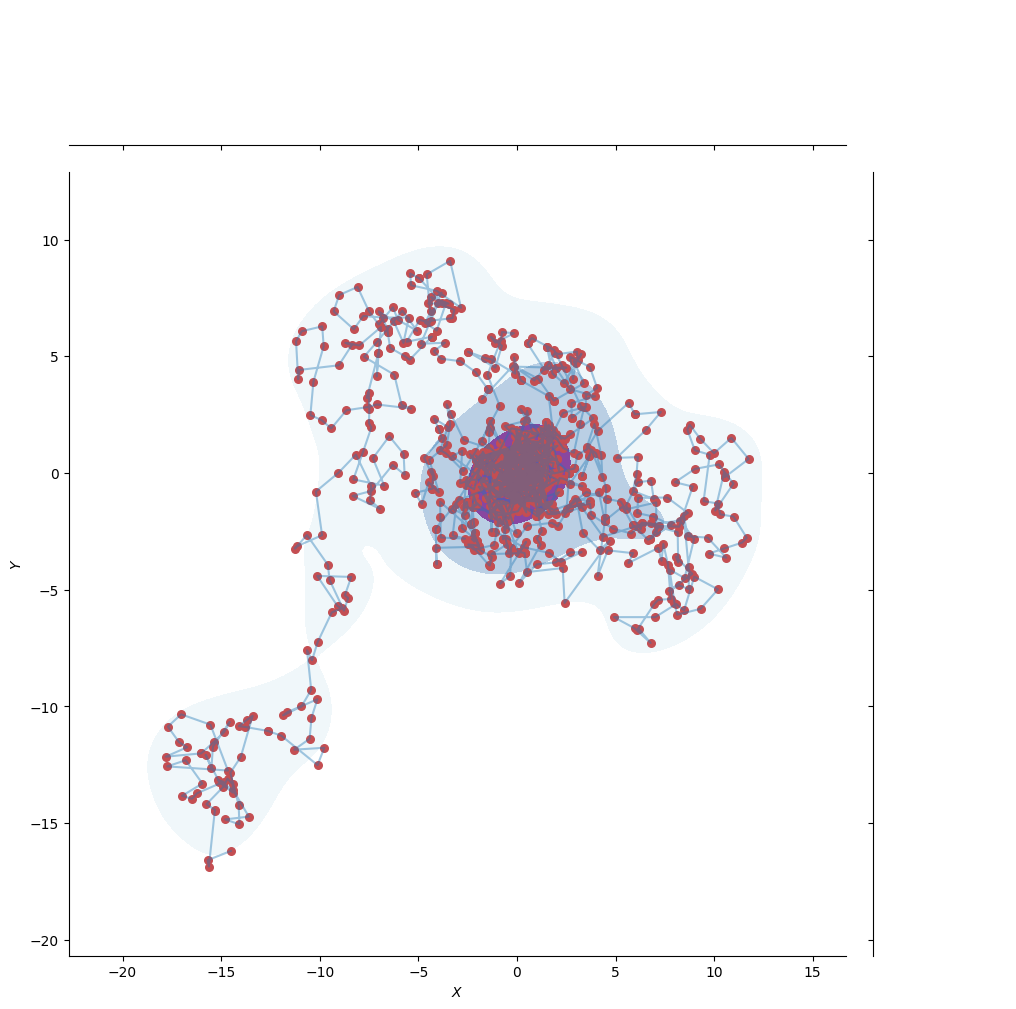

In [100]:
# generate the samples
samples = metropolis_hastings(ptarget, 1000, 1, 1, 0.8)  # Para Cauchy

# visualise
plot_dist(samples[:, 0], samples[:, 1])
plt.savefig('caminates_cauchy.png')


# M E D I A - D E S V. E S T Á N D A R

* **MEDIA:** La media de la distribución Cauchy no está definida. A diferencia de otras distribuciones, la Cauchy tiene colas pesadas que impiden que se pueda calcular la media de manera convencional.

* **VARIANZA:** La varianza también está indefinida. Al igual que la media, la varianza no existe para la distribución Cauchy debido a las propiedades de las colas pesadas.

* **DESV.ESTÁNDAR:** Al igual que la media y la varianza, la desviación estándar no está definida en la distribución Cauchy.

Pero podemos ver cual serian estos valores aunque no son 100% recomendables.

In [102]:
# Calcular la media
mean_x1 = np.mean(samples[:, 0]).round(2)  # Media para X
mean_y1 = np.mean(samples[:, 1]).round(2)  # Media para Y

# Calcular la varianza
var_x1 = np.var(samples[:, 0]).round(2)     # Varianza para X
var_y1 = np.var(samples[:, 1]).round(2)     # Varianza para Y

# Calcular la desviación estándar
std_x1 = np.std(samples[:, 0]).round(2)     # Desviación estándar para X
std_y1 = np.std(samples[:, 1]).round(2)     # Desviación estándar para Y

# Imprimir los resultados
print(f"Media de X: {mean_x1}, Media de Y: {mean_y1}")
print(f"Varianza de X: {var_x1}, Varianza de Y: {var_y1}")
print(f"Desviación estándar de X: {std_x1}, Desviación estándar de Y: {std_y1}")

Media de X: -0.73, Media de Y: -0.49
Varianza de X: 27.04, Varianza de Y: 16.19
Desviación estándar de X: 5.2, Desviación estándar de Y: 4.02


# EJEMPLO 3: Distribución Uniforme Bivariada

Si $X$ está distribuido uniformemente en el intervalo $[a_1,b_1]$ y $Y$ en $[a_2,b_2]$, la función de densidad conjunta de la distribución uniforme bivariada es:

$$f(x,y)=  \left\{ \begin{array}{lcc} \frac{1}{(b_1-a_1)(b_2-a_2)} & si & a_1 \leq x \leq b_1 \text{ y } a_2 \leq y \leq b_2   \\ \\ 0  & \text{ en otro caso} \end{array} \right.$$

Esto significa que la probabilidad se distribuye uniformemente sobre el rectángulo $$[a_1,b_1]*[a_2,b_2]$$
y fiera de este intervalo la probabilidad es 0.

In [122]:
# Definimos nuestra función para la Distribución Bivariada Uniforme
def bivariate_uniform(X, Y, xmin=-5, xmax=5, ymin=-5, ymax=5):
    # Retorna 1 si los puntos (X, Y) están dentro del rango, y 0 si están fuera
    Z = np.zeros_like(X)
    Z[(X >= xmin) & (X <= xmax) & (Y >= ymin) & (Y <= ymax)] = 1
    return Z


In [123]:
def plot_dist(x,y):
    sns.set_style('white')  # Color del fondo
    plt.rcdefaults()

    # plot contour
    g = sns.JointGrid(x=x, y=y, height=10).plot_joint(sns.kdeplot, n_levels=4, cmap="BuPu", shade=True, shade_lowest=False)

    # add scatter plot of data
    g = g.plot_joint(plt.scatter, c="r", s=30, linewidth=1)
    plt.plot(x, y, linestyle='-', marker='', alpha=0.4)

    # set axis labels
    g.set_axis_labels("$X$", "$Y$")

In [124]:
def traceplot(x):
    sns.tsplot(x)
    l = list(accumulate(x))
    nl = [v/i for i, v in enumerate(l,1)]
    plt.plot(nl, 'r')
    plt.axhline(y=0.0, color='k', linestyle='--')
    plt.ylabel('x')
    plt.xlabel('Iteration')

In [125]:
def autocorrelation_plot(x, l):
    '''plots the autocorrelation of x to lag = l'''
    plt.acorr(x - np.mean(x), maxlags=l,  normed=True, usevlines=False)
    plt.xlim((0, 100))
    plt.ylabel('Autocorrelation')
    plt.xlabel('Lag')


In [130]:
# Definimos los límites de la distribución uniforme
xmin, xmax = -1, 8
ymin, ymax = -1, 8


Text(0.5, 0, '$p(x,y)$')

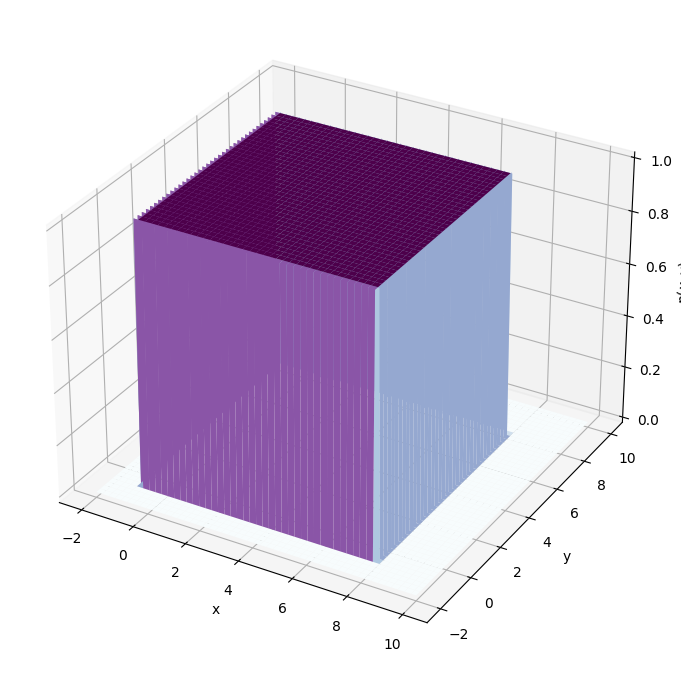

In [146]:
# Creamos la malla de un gráfico en 3D
x, y = np.linspace(-2, 10, 200), np.linspace(-2, 10, 200)  # El rango se extiende un poco más allá del área de soporte
X, Y = np.meshgrid(x, y)

# Generamos la distribución uniforme bivariada
Z = bivariate_uniform(X, Y, xmin, xmax, ymin, ymax)

# Gráfico de superficie en 3D
fig = plt.figure(figsize=(12,8.5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap= 'BuPu')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$p(x,y)$')

In [132]:
# Definimos la función de probabilidad objetivo
def ptarget(x, y):
    if xmin <= x <= xmax and ymin <= y <= ymax:
        return 1.0  # Probabilidad uniforme en el rango
    else:
        return 0.0  # Fuera del rango, probabilidad 0


In [133]:
# Algoritmo de Metropolis-Hastings
def metropolis_hastings(p, n, x0, y0, step):
    x = x0
    y = y0

    points = np.zeros((n, 2))  # Lista inicial de muestras, al momento, con puros ceros

    for i in range(n):
        # Proponemos nuevos valores para el estado actual mediante el muestreo Q(x',y' | x,y)
        x_star, y_star = np.array([x, y]) + np.random.normal(scale=step, size=2)

        # Condición de Metropolis-Hastings
        if np.random.rand() < min(1, p(x_star, y_star) / p(x, y)):
            x, y = x_star, y_star

        # Se actualiza la lista de muestras
        points[i] = np.array([x, y])

    return points


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1832: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1832: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)


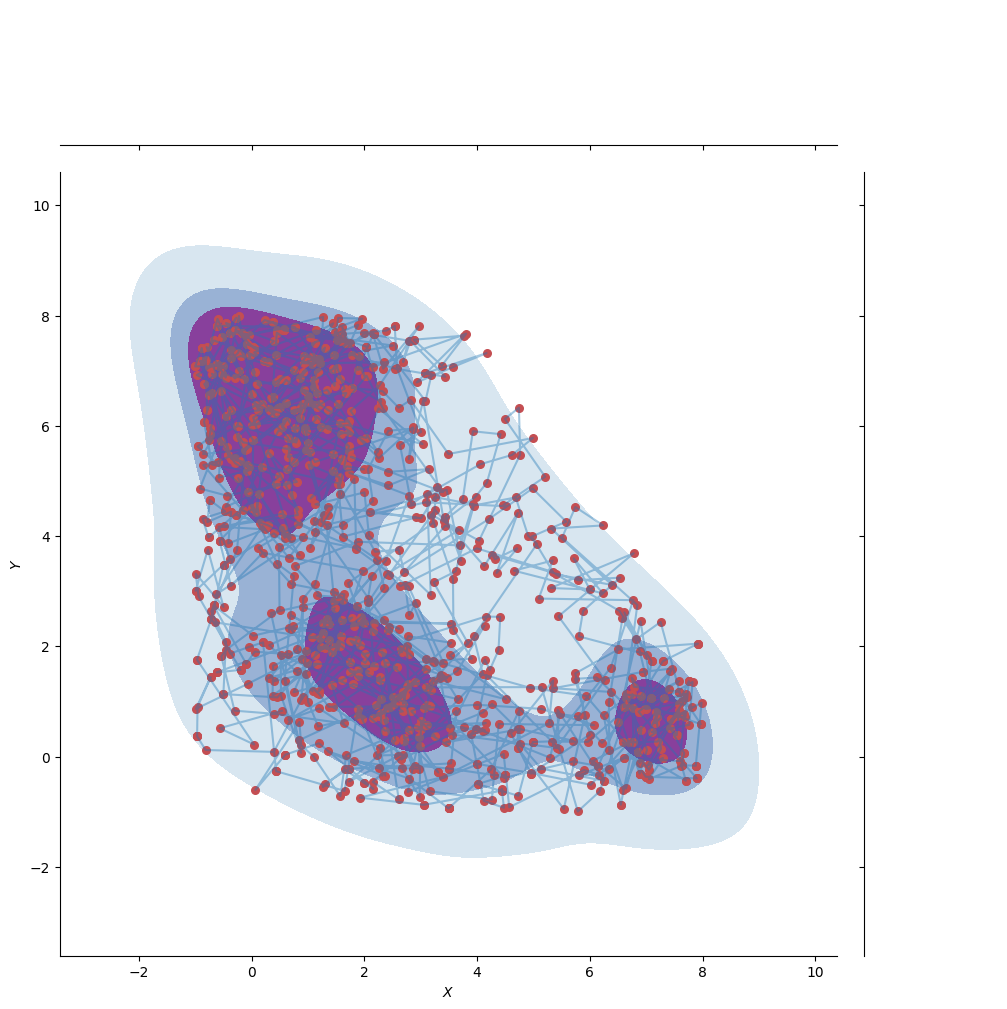

In [134]:
# Generamos las muestras
samples = metropolis_hastings(ptarget, 1000, 0, 0, 0.8)  # Para la distribución uniforme

# Visualizamos las muestras
plot_dist(samples[:, 0], samples[:, 1])
plt.savefig('caminates_uniforme.png')

# M E D I A - D E S V. E S T Á N D A R

* **MEDIA:** Para una variable $X$ distribuida uniformemente en $[a_1 , b_1]$, la media es

$$\mu_X = \frac{a_1 + b_1}{2}=\frac{-1+8}{2}=3.5$$

análogamente, para $Y$ disteibbuida en $[a_2,b_2]$, la media es:

$$\mu_Y = \frac{a_2+b_2}{2}=\frac{-1+8}{2}=3.5$$

asi la media conjunta es:

$$ \mu(X,Y) = (3.5,3.5)$$

* **VARIANZA:** Para $X$ uniformemente distribuido, la varianza es:

$$Var(X)= \frac{(b_1-a_1)^2}{12} = \frac{(8+1)^2}{12} = \approx 4.0833 $$

análogamente, la varianza de $Y$ es:

$$Var(Y)= \frac{(b_2-a_2)^2}{12} = \frac{(8+1)^2}{12}=\approx 4.0833$$

* **DESV. ESTÁNDAR:** La desviación estándar es simplemente la raíz cuadrada de la varianza. Por lo tanto, para $X$:

$$ \sigma_X = \sqrt{\frac{(b_1-a_1)^2}{12}} = \frac{b_1-a_1}{\sqrt{12}} =  \sqrt{\frac{(8+1)^2}{12}}\approx 2.59$$

y para $Y$

$$\sigma_Y = \frac{b_2 - a_2}{\sqrt{12}}= \sqrt{\frac{(8+1)^2}{12}}\approx 2.59$$

In [135]:
# Calcular la media
mean_x2 = np.mean(samples).round(2)  # Media para X
mean_y2 = np.mean(samples).round(2)  # Media para Y

# Calcular la varianza
var_x2 = np.var(samples).round(2)     # Varianza para X
var_y2 = np.var(samples).round(2)     # Varianza para Y

# Calcular la desviación estándar
std_x2 = np.std(samples).round(2)     # Desviación estándar para X
std_y2 = np.std(samples).round(2)     # Desviación estándar para Y

# Imprimir los resultados
print(f"Media de X: {mean_x2}, Media de Y: {mean_y2}")
print(f"Varianza de X: {var_x2}, Varianza de Y: {var_y2}")
print(f"Desviación estándar de X: {std_x2}, Desviación estándar de Y: {std_y2}")

Media de X: 2.93, Media de Y: 2.93
Varianza de X: 7.23, Varianza de Y: 7.23
Desviación estándar de X: 2.69, Desviación estándar de Y: 2.69


# EJEMPLO 4: Distribución Beta Bivariada

La función de densidad conjunta de la distribución Beta bivariada tiene una forma algo compleja, la cual está definida como:

$$f(x,y;\alpha_1,\beta_1,\alpha_2,\beta_2,\rho) = C * x^{\alpha_1 - 1} (1-x)^{\beta_1 -1}* y^{\alpha_2 -1}(1-y)^{\beta_2 - 1} * (1-\rho x y)$$

In [137]:
# Definimos nuestra función para la Distribución Bivariada Beta
def bivariate_beta(X, Y, alpha1=2.0, beta1=5.0, alpha2=2.0, beta2=5.0):
    """
    Bivariate Beta distribution for *X* and *Y*.
    We assume X and Y are independent Beta distributions.
    """
    # Cálculo de las densidades Beta independientes
    Z_X = st.beta.pdf(X, alpha1, beta1)
    Z_Y = st.beta.pdf(Y, alpha2, beta2)

    # Producto de las densidades de X e Y para la distribución conjunta
    return Z_X * Z_Y

In [138]:
def plot_dist(x, y):
    ''' plotting environment we frequently use to visualise the
    sampling algorithms.'''

    sns.set_style('white')  # Color del fondo
    plt.rcdefaults()

    # plot contour
    g = sns.JointGrid(x=x, y=y, height=10).plot_joint(sns.kdeplot, n_levels=4, cmap="BuPu", shade=True, shade_lowest=False)

    # add scatter plot of data
    g = g.plot_joint(plt.scatter, c="r", s=30, linewidth=1)
    plt.plot(x, y, linestyle='-', marker='', alpha=0.4)

    # set axis labels
    g.set_axis_labels("$X$", "$Y$")

In [139]:
def traceplot(x):
    '''traceplot in the x-dimension with the cumulative mean (r)
    and the actual mean (--)'''
    sns.tsplot(x)
    l = list(accumulate(x))
    nl = [v/i for i, v in enumerate(l,1)]
    plt.plot(nl, 'r')
    plt.axhline(y=0.0, color='k', linestyle='--')
    plt.ylabel('x')
    plt.xlabel('Iteration')


In [140]:
def autocorrelation_plot(x, l):
    '''plots the autocorrelation of x to lag = l'''
    plt.acorr(x - np.mean(x), maxlags=l, normed=True, usevlines=False)
    plt.xlim((0, 100))
    plt.ylabel('Autocorrelation')
    plt.xlabel('Lag')

In [141]:
# Definimos los parámetros de la distribución Beta
alpha1, beta1 = 2, 5  # Parámetros para X
alpha2, beta2 = 2, 5  # Parámetros para Y


Text(0.5, 0, '$p(x,y)$')

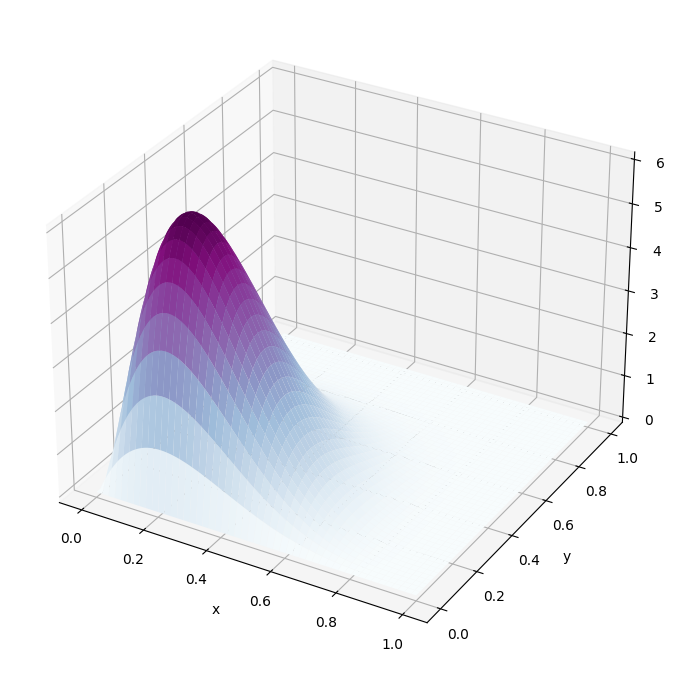

In [142]:
# Creamos la malla de un gráfico en 3D
x = np.linspace(0, 1, 200)  # La distribución Beta está definida en el intervalo [0,1]
y = np.linspace(0, 1, 200)
X, Y = np.meshgrid(x, y)

# Generamos la distribución Beta bivariada
Z = bivariate_beta(X, Y, alpha1, beta1, alpha2, beta2)

# Gráfico de superficie en 3D
fig = plt.figure(figsize=(12,8.5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap= 'BuPu')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$p(x,y)$')

In [143]:
# Definimos la función de probabilidad objetivo
def ptarget(x, y):
    if 0 <= x <= 1 and 0 <= y <= 1:
        return st.beta.pdf(x, alpha1, beta1) * st.beta.pdf(y, alpha2, beta2)  # Producto de las densidades Beta independientes
    else:
        return 0.0  # Fuera del rango, probabilidad 0

In [144]:
# Algoritmo de Metropolis-Hastings
def metropolis_hastings(p, n, x0, y0, step):
    x = x0
    y = y0

    points = np.zeros((n, 2))  # Lista inicial de muestras, al momento, con puros ceros

    for i in range(n):
        # Proponemos nuevos valores para el estado actual mediante el muestreo Q(x',y' | x,y)
        x_star, y_star = np.array([x, y]) + np.random.normal(scale=step, size=2)

        # Aseguramos que las muestras propuestas estén dentro del dominio de la distribución Beta [0, 1]
        x_star = np.clip(x_star, 0, 1)
        y_star = np.clip(y_star, 0, 1)

        # Condición de Metropolis-Hastings
        if np.random.rand() < min(1, p(x_star, y_star) / p(x, y)):
            x, y = x_star, y_star

        # Se actualiza la lista de muestras
        points[i] = np.array([x, y])

    return points

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1832: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1832: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)


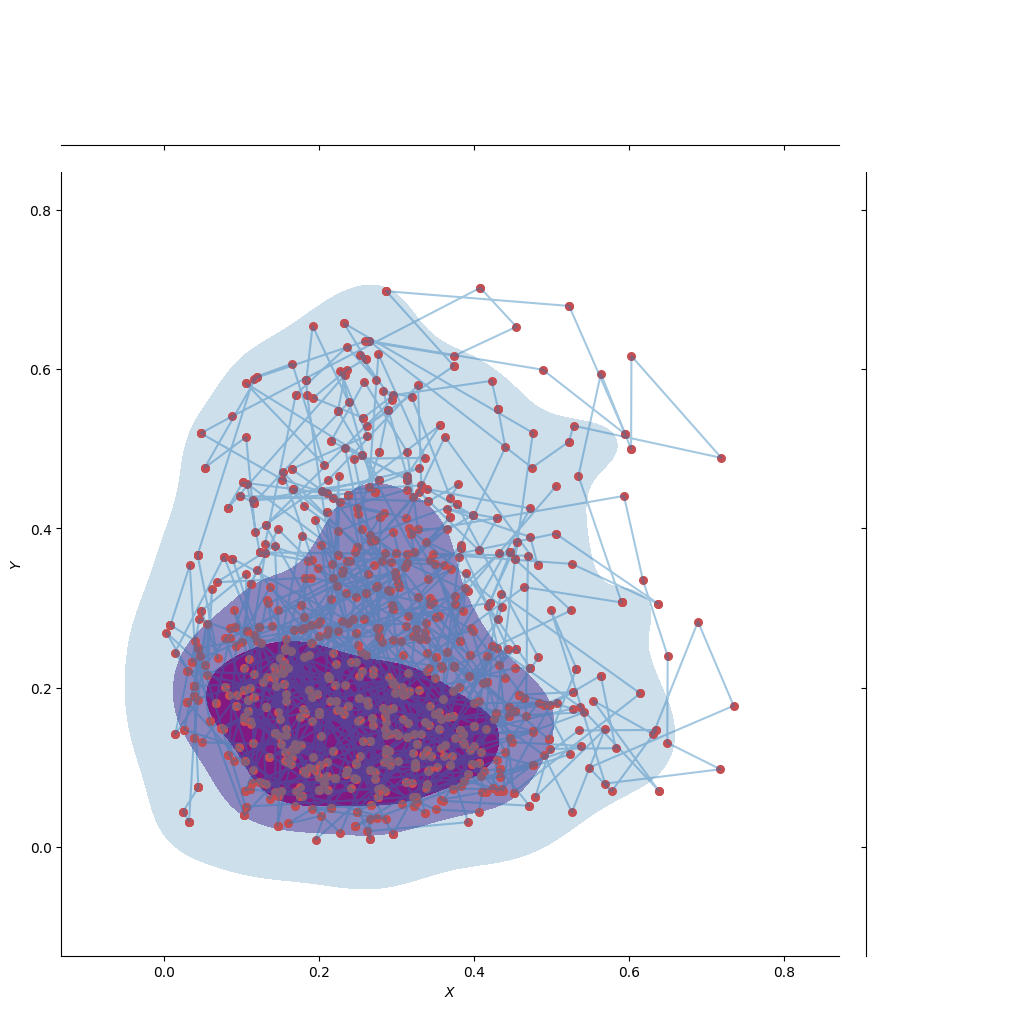

In [145]:
# Generamos las muestras
samples = metropolis_hastings(ptarget, 1000, 0.5, 0.5, 0.1)  # Para la distribución Beta bivariada

# Visualizamos las muestras
plot_dist(samples[:, 0], samples[:, 1])
plt.savefig('caminates_beta.png')

# M E D I A - D E S V. E S T Á N D A R

* **MEDIA:** La media para $X$ esta definida como

 $$\mu_X = \frac{\alpha_1}{\alpha_1 + \beta_1} = \frac{2}{2 + 5} \approx 0.2857 $$

 y la media para $Y$ es

 $$\mu_Y = \frac{\alpha_2}{\alpha_2 + \beta_2} = \frac{2}{2 + 5} \approx 0.2857$$

* **VARIANZA:** La varianza de $X$ esta definida como

 $$Var(X) = \frac{\alpha_1 \beta_1}{(\alpha_1 + \beta_1)^2 (\alpha_1 + \beta_1 + 1)}= \frac{2 (5)}{(2 + 5)^2 (2 + 5 + 1)} \approx 0.025 $$

 y para $Y$ es

 $$Var(Y) = \frac{\alpha_2 \beta_2}{(\alpha_2 + \beta_2)^2 (\alpha_2 + \beta_2 + 1)} = \frac{2 (5)}{(2 + 5)^2 (2 + 5 + 1)} \approx 0.025 $$

 finalmente la desviación estándar es:

$$\sigma_X = \sqrt{\frac{\alpha_1 \beta_1}{(\alpha_1 + \beta_1)^2 (\alpha_1 + \beta_1 + 1)}} = \sqrt{\frac{2 (5)}{(2 + 5)^2 (2 + 5 + 1)}} \approx 0.159$$

y para $Y$

$$\sigma_Y = \sqrt{\frac{\alpha_2 \beta_2}{(\alpha_2 + \beta_2)^2 (\alpha_2 + \beta_2 + 1)}}= \sqrt{\frac{2 (5)}{(2 + 5)^2 (2 + 5 + 1)}} \approx 0.159$$


In [147]:
# Calcular la media
mean_x3 = np.mean(samples).round(2)  # Media para X
mean_y3 = np.mean(samples).round(2)  # Media para Y

# Calcular la varianza
var_x3 = np.var(samples).round(2)     # Varianza para X
var_y3 = np.var(samples).round(2)     # Varianza para Y

# Calcular la desviación estándar
std_x3 = np.std(samples).round(2)     # Desviación estándar para X
std_y3 = np.std(samples).round(2)     # Desviación estándar para Y

# Imprimir los resultados
print(f"Media de X: {mean_x3}, Media de Y: {mean_y3}")
print(f"Varianza de X: {var_x3}, Varianza de Y: {var_y3}")
print(f"Desviación estándar de X: {std_x3}, Desviación estándar de Y: {std_y3}")

Media de X: 0.26, Media de Y: 0.26
Varianza de X: 0.02, Varianza de Y: 0.02
Desviación estándar de X: 0.15, Desviación estándar de Y: 0.15
